In [13]:
import numpy as np
from collections import Counter

class Node:
	def __init__(self, feature = None, threshold = None, left = None, right = None, *, value = None):
		''' Constructor '''

		# for decision node
		self.feature = feature
		self.threshold = threshold
		self.left = left
		self.right = right

		# for leaf node
		self.value = value

	def is_leaf_node(self):
		return self.value is not None
		
class DecisionTree:
	def __init__(self, min_samples_split = 2, max_depth = 100, n_features = None):
		''' Constructor '''

		# conditions
		self.min_samples_split = min_samples_split
		self.max_depth = max_depth
		self.n_features = n_features

		# initialize the root of tree node
		self.root = None

	def fit(self, X, y):
		''' Function to train the tree '''

		self.n_features = X.shape[1] if not self.n_features else min(X.shape[1], self.n_features)
		self.root = self._grow_tree(X, y)

	def _grow_tree(self, X, y, depth = 0):

		n_samples, n_feats = X.shape
		n_labels = len(np.unique(y))

		# check the stopping criteria
		if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
			leaf_value = self._most_common_label(y)

			return Node(value = leaf_value)

		feat_idxs = np.random.choice(n_feats, self.n_features, replace = False)

		# find the best split
		best_feature, best_thresh = self._best_split(X, y, feat_idxs)

		# create child nodes
		left_idxs, right_idxs = self._split(X[:, best_feature] ,best_thresh)
		left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
		right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
		return Node(best_feature, best_thresh, left, right)


	def _best_split(self, X, y, feat_idxs):
		best_gain = -1

		split_idx, split_threshold = None, None

		for feat_idx in feat_idxs:
			X_column = X[:, feat_idx]
			thresholds = np.unique(X_column)

			for threshold in thresholds:
				# calculate the information gain
				gain = self._information_gain(y, X_column, threshold)

				if gain > best_gain:
					best_gain = gain
					split_idx = feat_idx
					split_threshold = threshold

		return split_idx, split_threshold

	def _information_gain(self, y, X_column, threshold):
		''' IG = E(parent) - [weighted avg] . E(children) '''

		# parent entropy(E)
		parent_entropy = self._entropy(y)

		# create children
		left_idxs, right_idxs = self._split(X_column, threshold)

		if len(left_idxs) == 0 or len(right_idxs) == 0:
			return 0

		# calculate the weighted entropy of children
		n = len(y)
		n_l, n_r = len(left_idxs), len(right_idxs)
		e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
		child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

		# calculate the IG
		information_gain = parent_entropy - child_entropy
		return information_gain

	def _split(self, X_column, split_threshold):
		left_idxs = np.argwhere(X_column <= split_threshold).flatten()
		right_idxs = np.argwhere(X_column > split_threshold).flatten()
		return left_idxs, right_idxs

	def _entropy(self, y):
		''' E = - all(p(x) . log2(p(x)))
			p(x) =  #x/n '''

		# histogram
		# np.bincount([1, 2, 3, 1, 2, 1]) = [0, 3, 2, 1]
		# 0 occured 0 times, 1 occured 3 times, and so on
		hist = np.bincount(y)

		ps = hist / len(y)

		return -np.sum([p * np.log(p) for p in ps if p > 0])

	def _most_common_label(self, y):
		counter = Counter(y)
		value = counter.most_common(1)[0][0]
		return value

	def predict(self, X):
		return np.array([self._traverse_tree(x, self.root) for x in X])

	def _traverse_tree(self, x, node):
		if node.is_leaf_node():
			return node.value

		if x[node.feature] <= node.threshold:
			return self._traverse_tree(x, node.left)

		return self._traverse_tree(x, node.right)

In [14]:
from DecisionTree import DecisionTree
import numpy as np
from collections import Counter

class RandomForest:
	def __init__(self, n_trees = 10, max_depth = 10, min_samples_split = 2, n_feature = None):
		self.n_trees = n_trees
		self.max_depth = max_depth
		self.min_samples_split = min_samples_split
		self.n_features = n_feature
		self.trees = []

	def fit(self, X, y):
		self.trees = []
		for _ in range(self.n_trees):
			tree = DecisionTree(max_depth = self.max_depth, 
						 		min_samples_split = self.min_samples_split,
						 		n_features = self.n_features)

			X_sample, y_sample = self._bootstrap_samples(X, y)
			tree.fit(X_sample, y_sample)
			self.trees.append(tree)

	def _bootstrap_samples(self, X, y):
		n_samples = X.shape[0]
		idxs = np.random.choice(n_samples, n_samples, replace = True)
		return X[idxs], y[idxs]

	def _most_common_label(self, y):
		counter = Counter(y)
		most_common = counter.most_common(1)[0][0]
		return most_common

	def predict(self, X):
		predictions = np.array([tree.predict(X) for tree in self.trees])
		# [[1,0,1,1], [0,0,1,1], []]

		tree_preds = np.swapaxes(predictions, 0, 1)
		predictions = np.array([self._most_common_label(pred) for pred in tree_preds])
		return predictions

In [21]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
from RandomForest import RandomForest
from DecisionTree import DecisionTree

data = datasets.load_digits()

X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / len(y_test)

# Decision Tree
clf1 = DecisionTree(max_depth = 10)
clf1.fit(X_train, y_train)
predictions1 = clf1.predict(X_test)

acc1 = accuracy(y_test, predictions1)
print(f'Decision Tree Accuracy: {acc1}')

# Random Forest
clf2 = RandomForest(n_trees = 10)
clf2.fit(X_train, y_train)
predictions2 = clf2.predict(X_test)

acc2 = accuracy(y_test, predictions2)
print(f'Random Forest Accuracy: {acc2}')

Decision Tree Accuracy: 0.8916666666666667
Random Forest Accuracy: 0.9611111111111111


In [15]:
X,y = datasets.load_digits(return_X_y=True, as_frame=True)

In [16]:
print(f'Banyak data: {len(X)} \n')
print(X.dtypes)
print(f'\nData dalam 8x8 matriks: \n {data.images[0]}')

Banyak data: 1797 

pixel_0_0    float64
pixel_0_1    float64
pixel_0_2    float64
pixel_0_3    float64
pixel_0_4    float64
              ...   
pixel_7_3    float64
pixel_7_4    float64
pixel_7_5    float64
pixel_7_6    float64
pixel_7_7    float64
Length: 64, dtype: object

Data dalam 8x8 matriks: 
 [[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]


In [18]:
hasil = clf1.predict(np.array(data.images[150]).reshape(1,-1))
print(hasil)


[0]


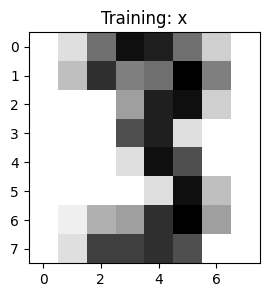

In [43]:
# test = np.array([0,0,5,13,9,1,0,0,0,0,13,15,10,15,5,0,0,3,15,2,0,11,8,0,0,4,12,0,0,8,8,0,0,5,8,0,0,9,8,0,0,4,11,0,1,12,7,0,0,2,14,5,10,12,0,0,0,0,6,13,10,0,0,0,0]).reshape(1,-1)
# print(np.array(data.images[150]).reshape(1,-1))
hasil = clf2.predict(np.array(data.images[12]).reshape(1,-1))
# hasil_test = clf.predict(test)

# test_resize = np.resize(test,(8,8))
# print(test_resize)
plt.figure(1, figsize=(3, 3))
plt.imshow(data.images[13], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title('Training: x')
plt.show()


[[ 0  2 15 16  6  0  0  0]
 [ 0  5 16 15 14  0  0  0]
 [ 0  5 13 10 14  0  0  0]
 [ 0  0  0 12 12  0  0  0]
 [ 0  0  1 16  7  0  0  0]
 [ 0  0 10 15  2  0  0  0]
 [ 0  3 16 10  8  6  1  0]
 [ 0  2 15 16 16 16  7  0]]


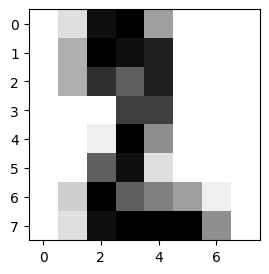

[2]


In [138]:
test2 = np.array([0,2,15,16,6,0,0,0,0,5,16,15,14,0,0,0,0,5,13,10,14,0,0,0,0,0,0,12,12,0,0,0,0,0,1,16,7,0,0,0,0,0,10,15,2,0,0,0,0,3,16,10,8,6,1,0,0,2,15,16,16,16,7,0,2]).reshape(1, -1)
test_resize = np.resize(test2,(8,8))
print(test_resize)
plt.figure(1, figsize=(3, 3))
plt.imshow(test_resize, cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

hasil_test2 = clf.predict(test2)

print(hasil_test2)

In [16]:
print(y.dtypes)

int32


In [139]:
import imageio.v2 as imageio

pic_path = 'test1.jpeg'

img = imageio.imread(pic_path)
# dirty hack to tranform into the format, sklearn needs it

# rounded = [numpy.round(x) for x in predictions]
img = [16-int(np.round(jj/16)) for j in img for jj in j]

predicted = classifier.predict(img)


image = np.reshape(img, (8,8))
plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
plt.axis('off')
plt.show()

print('Predicted: {0}'.format(predicted))


# img = plt.imread(pic_path)
    
# gray = rgb2gray(img)
# a = (16-gray*16).astype(int)
# plt.imshow(a, cmap = plt.get_cmap('gray_r'))
# plt.show()
# print("source data in 8x8:\n",a)

# predicted = classifier.predict(a.flatten().reshape(1, -1))
# print(predicted)

TypeError: only size-1 arrays can be converted to Python scalars

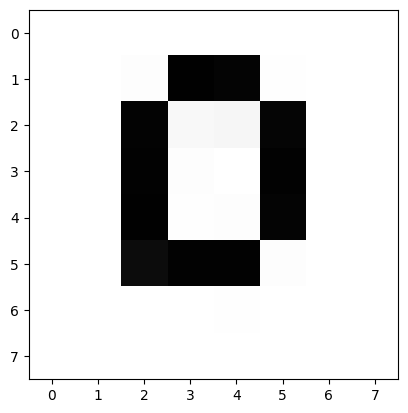

[9]


In [123]:
import cv2

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

path = 'resize1.jpeg'
grayscale = cv2.imread(path)
grayscale = cv2.resize(grayscale, (8,8))
# a= np.reshape(gray, (8,8))
plt.imshow(grayscale, cmap = plt.get_cmap('gray_r'))
plt.show()
# print("source data in 8x8:\n",a)

predicted = clf.predict(grayscale.flatten().reshape(1, -1))
print(predicted)

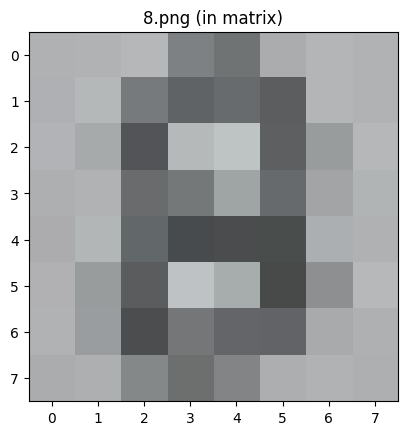

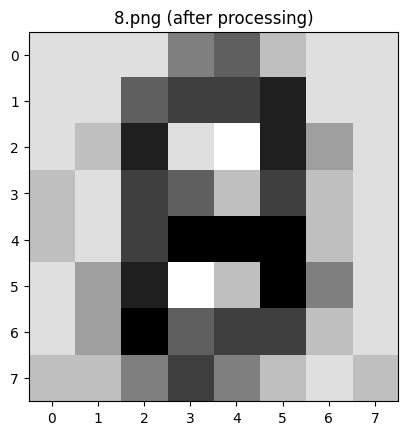

source data in 8x8:
 [[ 4  4  4  7  8  5  4  4]
 [ 4  4  8  9  9 10  4  4]
 [ 4  5 10  4  3 10  6  4]
 [ 5  4  9  8  5  9  5  4]
 [ 5  4  9 11 11 11  5  4]
 [ 4  6 10  3  5 11  7  4]
 [ 4  6 11  8  9  9  5  4]
 [ 5  5  7  9  7  5  4  5]]

Hasil prediksi angka dari gambar adalah angka 8


In [40]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2

path = '8.png'

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

img = mpimg.imread(path)

plt.imshow(img, cmap=plt.cm.gray_r, interpolation='nearest')
plt.title('8.png (in matrix)')
plt.show()

gray = rgb2gray(img)

a=(16-gray*16).astype(int)

plt.imshow(a, cmap=plt.cm.gray_r, interpolation='nearest')
plt.title('8.png (after processing)')
plt.show()

predicted = clf2.predict(a.flatten().reshape(1, -1))

print("source data in 8x8:\n",a)
print(f'\nHasil prediksi angka dari gambar adalah angka {predicted[0]}')